Import necessary packages: Numpy, Pandas, matplotlib

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

Mount your google drive (if you have a google account) or upload files (go on the file icon on the left -> right click). Copy path of zip.train and zip.test and load them as numpy arrays using the following code (insert the path as string).

In [3]:
#path_to_train = '/content/drive/My Drive/ML_Class_2020/KNN/zip.train'
#path_to_test = '/content/drive/My Drive/ML_Class_2020/KNN/zip.test'
path_to_train = 'zip.train'
path_to_test = 'zip.test'
training_data = np.array(pd.read_csv(path_to_train, sep=' ', header=None))
test_data = np.array(pd.read_csv(path_to_test, sep =' ',header=None))

X_train, y_train = training_data[:,1:-1], training_data[:,0]
X_test, y_test = test_data[:,1:], test_data[:,0]

# We only want to classify two different digits. Note the only difference is
# that we don't load as many ones as we load zeros.

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1][:30]
X_train = np.vstack((X_train_0, X_train_1))

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1][:30]
y_train = np.hstack((y_train_0, y_train_1))

X_test_0 = X_test[y_test == 0]
X_test_1 = X_test[y_test == 1][:12]
X_test = np.vstack((X_test_0, X_test_1))

y_test_0 = y_test[y_test == 0]
y_test_1 = y_test[y_test == 1][:12]
y_test = np.hstack((y_test_0, y_test_1))
print(y_test.shape)

(371,)


In [4]:
def show_numbers(X):
    num_samples = 90
    indices = np.random.choice(range(len(X)), num_samples)
    print(indices.shape)
    sample_digits = X[indices]

    fig = plt.figure(figsize=(20, 6))

    for i in range(num_samples):
        ax = plt.subplot(6, 15, i + 1)
        img = 1-sample_digits[i].reshape((16, 16)) 
        plt.imshow(img, cmap='gray')
        plt.axis('off')


(90,)


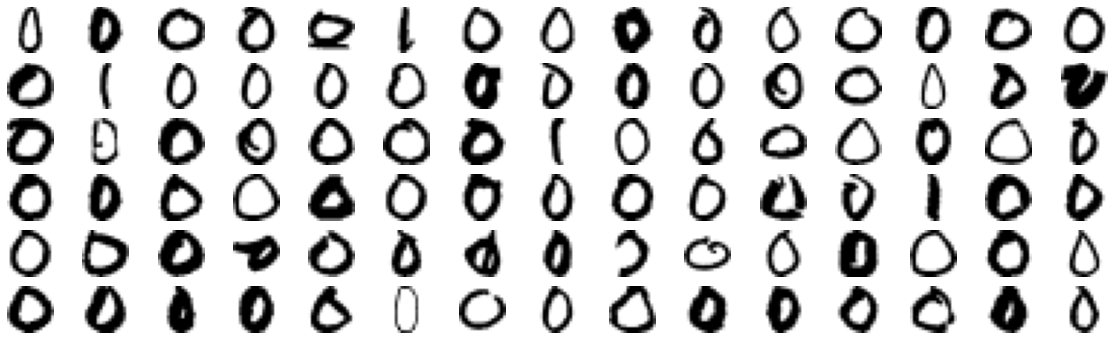

In [5]:
show_numbers(X_test)

Choose one of the classifiers you implemented and use it on the following task: Take a look at the provided notebook. It loads the ZIP-Code’s zeros and ones, but now there are manymore zeros than there are ones. We are going to believe that these digits represent geneticdata. Actually, we are virologists trying to develop a test to determine which of the data belongs to infected patients (the ones) and which do not (the zeros). Train/apply your model on the data and do the tasks of the exercise.

# Exercise 1. Cross-Validation
Use a 5-fold Cross-Validation to evaluate your model and optimize hyperparameters (e.g.
the threshold in Logistic Regression or k in K-NNs). Print the mean and variance of your
validation. What do both values tell you about your model?

### 1.1) kNN Implementation

In [6]:
class KNearestNeighbors:
    '''
    Think about defining more functions that will help you building this algorithm.
    Optimally, one that takes in k and a test image as a parameter.
    '''
    def squared_euclidean_distance(self, x_1, x_2):
      '''
      np.sum(x, axis = 1) will be summing all elements over the pixel dimension (axis = 1)
      '''
      return np.sum((x_1-x_2)**2, axis = 1)

    def __init__(self, k): 
        self.k = k
    
    def get_neighbourhood(self, X_train, X_test_set):
        return self.squared_euclidean_distance(X_train, X_test_set)
    
    def get_k_smallest_distances(self, distances):
        enumerated = list(enumerate(distances))
        index_sorted = sorted(enumerated, key=lambda x:x[1])
        return [index_sorted[i][0] for i in range(self.k)]
    
    def get_average_voted_y_label(self, Y_train, k_smallest_pos):
        selected_labels = np.array([int(Y_train[i]) for i in k_smallest_pos])
        return np.argmax(np.bincount(selected_labels))
                
    def classify_single(self, X_train, Y_train, X_test_set):
        distances = self.get_neighbourhood(X_train, X_test_set)
        k_smallest_pos = self.get_k_smallest_distances(distances)
        return self.get_average_voted_y_label(Y_train, k_smallest_pos)
        
    def classify_loop(self, X_train, Y_train, X_test):
        return [self.classify_single(X_train, Y_train, X_test_set) for X_test_set in X_test] 
    
def calculate_accuracy(true_y, pred_y, classes):
    class_sum = 0
    for class_num in classes:
        val_sum = 0
        for true_val, pred_val in zip(true_y, pred_y): 
            if class_num == true_val:
                if true_val == pred_val:
                    val_sum += 1
        class_sum += val_sum
    return class_sum / len(true_y)

### 1.2) Cross-Validation Implementation

In [7]:
# Task 1: split the training set into training and validation set -> 80:20 split
#         use KNN for classification of train set
#         do this 5-times -> cross-validation
#import random

def cross_validation(X_train, y_train, Ks, nr_folds = 5):
    all_accuracies = []
    #shoudn't the random shuffle only happen only once, then loop through the shuffled folds
    indices = np.arange(len(X_train))
    np.random.shuffle(indices)
    fold_indices_list = np.array_split(indices, nr_folds)
    for fold_counter, val_indices in enumerate(fold_indices_list):
#         same as above, only shuffle once
#         choices = list(range(len(X_train)))
#         random.shuffle(choices) 
#         val_indeces = [x for x in choices if x not in train_indeces]

        X_val = X_train[val_indices]
        y_val = y_train[val_indices]
        X_training = np.delete(X_train, val_indices, 0)
        y_training = np.delete(y_train, val_indices, 0)

        accuracy_list = []
        for k in Ks:
            kNN = KNearestNeighbors(k)
            y_pred = kNN.classify_loop(X_training, y_training, X_val)
            accuracy_list += [calculate_accuracy(y_val, y_pred, list(range(2)))]
        all_accuracies += [accuracy_list]
    return(np.array(all_accuracies))

### 1.3) Show the mean and variance of Validation Accuracies for different k's

In [8]:
Ks = range(2,21)
nr_folds = 5
acc = cross_validation(X_train, y_train, Ks, nr_folds)

In [9]:
acc_T = acc.T
acc_T

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [10]:
# mean of accuracy per k:
for row in acc_T:
    print(np.mean(row))
# np.mean(acc_T, axis=1)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [11]:
# variance of accuracy per k:
import statistics
for row in acc_T:
    print(statistics.variance(row))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


# Exercise 2. Confusion Matrix
Calculate the confusion matrix of your model.

### a) How many true positive/true negative/false positive/false negative observations are there?

In [40]:
def calculate_confusion_matrix(y_pred, y_true, class_label_list):
    """
    Returns a confusion matrix (ndarray) for all class labels given in class_label_list.
    The order of class_label_list is preserved.
    The first returned dimension(rows) are the predicted labels, the second one(columns) are the true labels.
    """
    confusion_matrix = []
    for class_label_pred in class_label_list:
        class_row = []
        for class_label_true in class_label_list:
            bool_pred = (y_pred == class_label_pred)
            bool_true = (y_true == class_label_true)
            occurrences = np.sum(np.logical_and(bool_pred, bool_true))
            class_row.append(occurrences)
        confusion_matrix.append(class_row)
    return np.array(confusion_matrix)

def display_confusion_matrix(y_pred, y_true, class_label_list):
    """Returns a labeled pandas DataFrame made from a confusion matrix (ndarray)"""
    confusion_matrix = calculate_confusion_matrix(y_pred, y_true, class_label_list)
    pred_labels = ["pred: " + str(x) for x in class_label_list]
    true_labels = ["true: " + str(x) for x in class_label_list]
    return pd.DataFrame(confusion_matrix, index=pred_labels, columns=true_labels)

In [32]:
# just selected k = 5 empirically
kNN = KNearestNeighbors(5)
y_pred_confusion = np.array(kNN.classify_loop(X_train, y_train, X_test))

In [54]:
# set 1 as the first/positive class and 0 as the second/negative class
class_label_list = np.unique(y_test)[::-1]
class_label_list

array([1., 0.])

In [55]:
display_confusion_matrix(y_pred_confusion, y_test, class_label_list)

,true: 1.0,true: 0.0
pred: 1.0,12,1
pred: 0.0,0,358


### b) Calculate the precision, recall, F1-score of your model. Compare it to a baseline (model) that always predicts negative (zero) for every sample. What is the difference between accuracy and F1-score?


In [69]:
def calculate_evaltuation_metrics(y_pred, y_true, class_label_list):
    """
    Returns prediction evaluation metrics in a dictionary.
    All single class metrics are reported as an array, 
    where position i represents the metric value for the class at class_label_list[i]
    """
    evaltuation_metrics = {}
    confusion_matrix = calculate_confusion_matrix(y_pred, y_true, class_label_list)
    evaltuation_metrics["accuracy"] = np.sum(confusion_matrix.diagonal()) / np.sum(confusion_matrix)
    
    precisions = []
    for i in range(len(class_label_list)):
        precisions.append(confusion_matrix[i][i] / np.sum(confusion_matrix[i]))
    evaltuation_metrics["precision"] = np.array(precisions)
    
    recalls = []
    confusion_matrix_t = confusion_matrix.T
    for i in range(len(class_label_list)):
        recalls.append(confusion_matrix_t[i][i] / np.sum(confusion_matrix_t[i]))
    evaltuation_metrics["recall"] = np.array(recalls)
    
    evaltuation_metrics["f1-score"] = 2 / ((1 / evaltuation_metrics["precision"]) + (1 / evaltuation_metrics["recall"]))
    
    return evaltuation_metrics

def print_metrics(metrics):
    for key in metrics:
        if type(metrics[key]) is np.ndarray:
            for class_label, entry in zip(class_label_list, metrics[key]):
                print(key, "class", class_label, ":", entry)
        else:
            print(key, metrics[key])

In [72]:
# print the metrics for the kNN model from Task a 
class_label_list = np.unique(y_test)[::-1]
print(display_confusion_matrix(y_pred_confusion, y_test, class_label_list))
print()
metrics_kNN = calculate_evaltuation_metrics(y_pred_confusion, y_test, class_label_list)
print_metrics(metrics_kNN)

           true: 1.0  true: 0.0
pred: 1.0         12          1
pred: 0.0          0        358

accuracy 0.9973045822102425
precision class 1.0 : 0.9230769230769231
precision class 0.0 : 1.0
recall class 1.0 : 1.0
recall class 0.0 : 0.9972144846796658
f1-score class 1.0 : 0.9600000000000002
f1-score class 0.0 : 0.9986052998605299


In [71]:
# print the metrics for a model that just sets everything to 0
y_pred_all_0 = np.zeros(len(y_test))
class_label_list = np.unique(y_test)[::-1]
print(display_confusion_matrix(y_pred_all_0, y_test, class_label_list))
print()
metrics_all_0 = calculate_evaltuation_metrics(y_pred_all_0, y_test, class_label_list)
print_metrics(metrics_all_0)

           true: 1.0  true: 0.0
pred: 1.0          0          0
pred: 0.0         12        359

accuracy 0.967654986522911
precision class 1.0 : nan
precision class 0.0 : 0.967654986522911
recall class 1.0 : 0.0
recall class 0.0 : 1.0
f1-score class 1.0 : nan
f1-score class 0.0 : 0.9835616438356165


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide


### c) If your test is positive, what is the probability for a patient to be actually positive. Would you recommend using the test you developed? Describe what the problem is if there is one.